# Интеллектуальный анализ данных – весна 2025

# Домашнее задание 7: Деревья. Случайный лес

Правила:

- Домашнее задание оценивается в 10 баллов.


- Можно использовать без доказательства любые результаты, встречавшиеся на лекциях или семинарах по курсу, если получение этих результатов не является вопросом задания.


- Можно использовать любые свободные источники с обязательным указанием ссылки на них.


- Плагиат не допускается. При обнаружении случаев списывания, 0 за работу выставляется всем участникам нарушения, даже если можно установить, кто у кого списал.

<img src="https://raw.githubusercontent.com/vasyukov1/HSE-FCS-SE-2-year/refs/heads/main/IAD/homeworks/hw07-trees/meme.jpg" alt="meme_lion" style="width: 700px;"/>

## Часть 1: Основы построения решающие дерева (1.5 балла)

В этой части все расчёты необходимо реализовывать в виде запрограммированных формул, например, на `numpy`. **Нельзя использовать готовые реализации**. Например, если в задании требуется рассчитать энтропию, то требуется в каком-то виде релизовать расчёт по формуле, но нельзя использовать готовую реализацию `some_module.entropy()`.

In [198]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

**Задание 1.1 (0.5 балла)** Пусть известно, что в вершину решающего дерева попали 10 объектов, 8 из которых имеют метку класса $k_1$, а 2 имеют метку класса $k_2$. Рассчитайте энтропию такого распределения классов (с натуральным логарифмом). Ответ округлите до двух знаков после запятой.

In [199]:
def entropy(k: np.array) -> float:
    n = np.sum(k)
    p = k / n
    p = p[p > 0]
    return -np.sum(p * np.log(p))

In [200]:
k = np.array([8, 2])
print(f"{entropy(k):.2f}")

0.50


**Задание 1.2 (0.5 балла)** Пусть дополнительно известно, что вершина из предыдущего задания не является листовой и возможно такое разбиение, что в левое поддерево попадут все объекты класса $k_1$, а в правое - класса $k_2$. Посчитайте критерий информативности:

$$
Q(R_m, j, t) = H(R_m) - \frac{|R_\ell|}{|R_m|}H(R_\ell) - \frac{|R_r|}{|R_m|}H(R_r),
$$

где $R_m$ - множество объектов в разбиваемой вершине, $j$ - номер признака, по которому происходит разбиение, $t$ - порог разбиения, $R_\ell$ - множество объектов в левом поддереве, $R_r$ - множество объектов в правом поддереве.

Теперь в качестве $H(R)$ будем использовать индекс Джини:

$$
H(R) = \sum_{k=1}^J p_k(1-p_k),
$$
где $J$ – общее количество классов (в нашем случае, $J = 2$).

Ответ округлите до двух знаков после запятой.

In [201]:
def H(y: np.ndarray) -> float:
    unique_classes, counts = np.unique(y, return_counts=True)
    probs = counts / counts.sum()
    return np.sum(probs * (1 - probs))

def Q(R_l: np.array, R_r: np.array) -> float:
    R_m = np.concatenate([R_l, R_r])
    return H(R_m) - (len(R_l) * H(R_l) + len(R_r) * H(R_r)) / len(R_m)

In [202]:
R_l = np.array([1 for i in range(8)])
R_r = np.array([2 for i in range(2)])

print(Q(R_l, R_r))

0.32


**Задание 1.3 (0.5 балла)** Пусть при построении дерева образовалась листовая вершина с 10 объектами, значения целевой переменной для которых следующие: [1, 10, 5, 18, 100, 30, 50, 61, 84, 47] (решается задача регрессии). Чему будут равны предсказания модели для этих объектов?

In [203]:
leaf_targets = np.array([1, 10, 5, 18, 100, 30, 50, 61, 84, 47])
leaf_prediction = np.mean(leaf_targets)
print(leaf_prediction)

40.6


## Часть 2: Решающие деревья (4.5 балла)

В этой части мы напишем и протестируем собственную реализацию решающего дерева.

In [204]:
from collections import Counter
from typing import Dict, List, Tuple, Union

**Задание 2.1 (1.5 балла)** Реализуйте функцию `find_best_split()`, которая должна находить оптимальное разбиение подмножества обучающей выборки в соответствии с информационным критерием из **Задания 1.2**. В качестве меры хаотичности $H(R)$ для задачи регрессии испольуйте дисперсию подвыборки, а для задачи классификации – критерий Джини (определён в том же задании).

Для категориальных признаков применяется наивный алгоритм разбиения: мы пытаемся найти одно значение, разбиение по которому сильнее всего увеличит критерий информативности. Иными словами, объекты с конкретным значением признака отправляем в левое поддерево, остальные - в правое. Обратите внимание, что это далеко не оптимальные способ учёта категориальных признаков. Например, можно было бы на каждое значение категориального признака создавать отдельное поддерево или использовать более сложные подходы. Подробнее об этом можно прочитать в конспектах [лекций](https://github.com/esokolov/ml-course-hse/blob/master/2019-fall/lecture-notes/lecture07-trees.pdf) по машинному обучению на ПМИ (раздел «Учёт категориальных признаков»).

В качестве подсказок реализации можете пользоваться кодом из бонусной части семинара по решающим деревьям.

**Бонус:** Разрешается делать цикл для перебора порогов, но возможна имплементация без него. За имплементацию без цикла – **бонус 1 балл**.

In [205]:
def variance(feature_vector: np.array) -> float:
    """
    :param feature_vector: значения признака объектов

    :return variance: несмещённая дисперсия по признакам
    """
    return np.var(feature_vector, ddof=0)

def split_sample(R: np.ndarray, y: np.ndarray, t: int) -> Tuple[np.ndarray, np.ndarray]:
    """
    :param R: значения признака объектов
    :param y: таргеты объектов
    :param t: порог деления

    :return left_tree: тергеты объектов, попавших в левое поддерево
    :return right_tree: тергеты объектов, попавших в правое поддерево
    """
    return y[R < t], y[R >= t]

def Q(R_l: np.array, R_r: np.array, task: str) -> float:
    """
    :param R_l: значения признака объектов в левом поддереве
    :param R_r: значения признака объектов в правом поддереве
    :param task: тип задачи: для регресии используется дисперсия, для классификации - коэфф. Джини

    :return Q: нечистота разбиения объектов
    """
    if len(R_l) == 0 or len(R_r) == 0:
        return -np.inf
    impurity = variance if task == "regression" else H
    R_m = np.concatenate([R_l, R_r])
    return impurity(R_m) - (len(R_l) * impurity(R_l) + len(R_r) * impurity(R_r)) / len(R_m)

def find_best_split(
    feature_vector: Union[np.ndarray, pd.DataFrame], 
    target_vector: Union[np.ndarray, pd.Series],
    task: str = "classification",
    feature_type: str = "real"
) -> Tuple[np.ndarray, np.ndarray, float, float]:
    """
    Указания:
    * Пороги, приводящие к попаданию в одно из поддеревьев пустого множества объектов, не рассматриваются.
    * В качестве порогов, нужно брать среднее двух сосдених (при сортировке) значений признака
    * Поведение функции в случае константного признака может быть любым.
    * При одинаковых приростах Джини или дисперсии нужно выбирать минимальный сплит.
    * За наличие в функции циклов балл будет снижен. Векторизуйте! :)

    :param feature_vector: вещественнозначный вектор значений признака
    :param target_vector: вектор классов объектов,  len(feature_vector) == len(target_vector)
    :param task: либо classification, либо regression
    :param feature_type: либо real, либо categorical
    
    :return thresholds: отсортированный по возрастанию вектор со всеми возможными порогами, по которым объекты можно
     разделить на две различные подвыборки, или поддерева
    :return ginis: вектор со значениями критерия Джини для каждого из порогов в thresholds len(ginis) == len(thresholds)
    :return threshold_best: оптимальный порог (число)
    :return gini_best: оптимальное значение критерия Джини (число)
    """

    if feature_type == "categorical":
        categories = np.unique(feature_vector)
        pos_ratios = {
            cat: target_vector[feature_vector == cat].mean()
            for cat in categories
        }
        sorted_cats = sorted(categories, key=lambda cat: pos_ratios[cat])
        cat_to_index = {cat: i for i, cat in enumerate(sorted_cats)}
        feature_vector = np.vectorize(cat_to_index.get)(feature_vector)

    sorted_indexes = np.argsort(feature_vector)
    features = np.asarray(feature_vector[sorted_indexes])
    targets = target_vector[sorted_indexes]

    diffs = features[:-1] != features[1:]
    thresholds = (features[:-1] + features[1:]) / 2
    thresholds = thresholds[diffs]

    if thresholds.size == 0:
        return np.array([]), np.array([]), None, None

    criteria = np.vectorize(lambda t: Q(*split_sample(features, targets, t), task))(thresholds)

    if np.all(np.isneginf(criteria)):
        return thresholds, criteria, None, None

    best_index = np.argmax(criteria)
    threshold_best = thresholds[best_index]
    gini_best = criteria[best_index]

    return thresholds, criteria, threshold_best, gini_best

Эту функцию можно протестировать на датасете `California`.

In [206]:
from sklearn.datasets import fetch_california_housing

In [207]:
data = fetch_california_housing()
X = pd.DataFrame(data=data["data"], columns=data["feature_names"])
y = data["target"]
X.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25


In [208]:
y

array([4.526, 3.585, 3.521, ..., 0.923, 0.847, 0.894])

Выведите график зависимости значения критерия ошибки от порогового значения при разбиении вершины по признаку `MedInc`.

In [209]:
thresholds, criteria, threshold_best, gini_best = find_best_split(X["MedInc"], y, task="regression", feature_type="real")

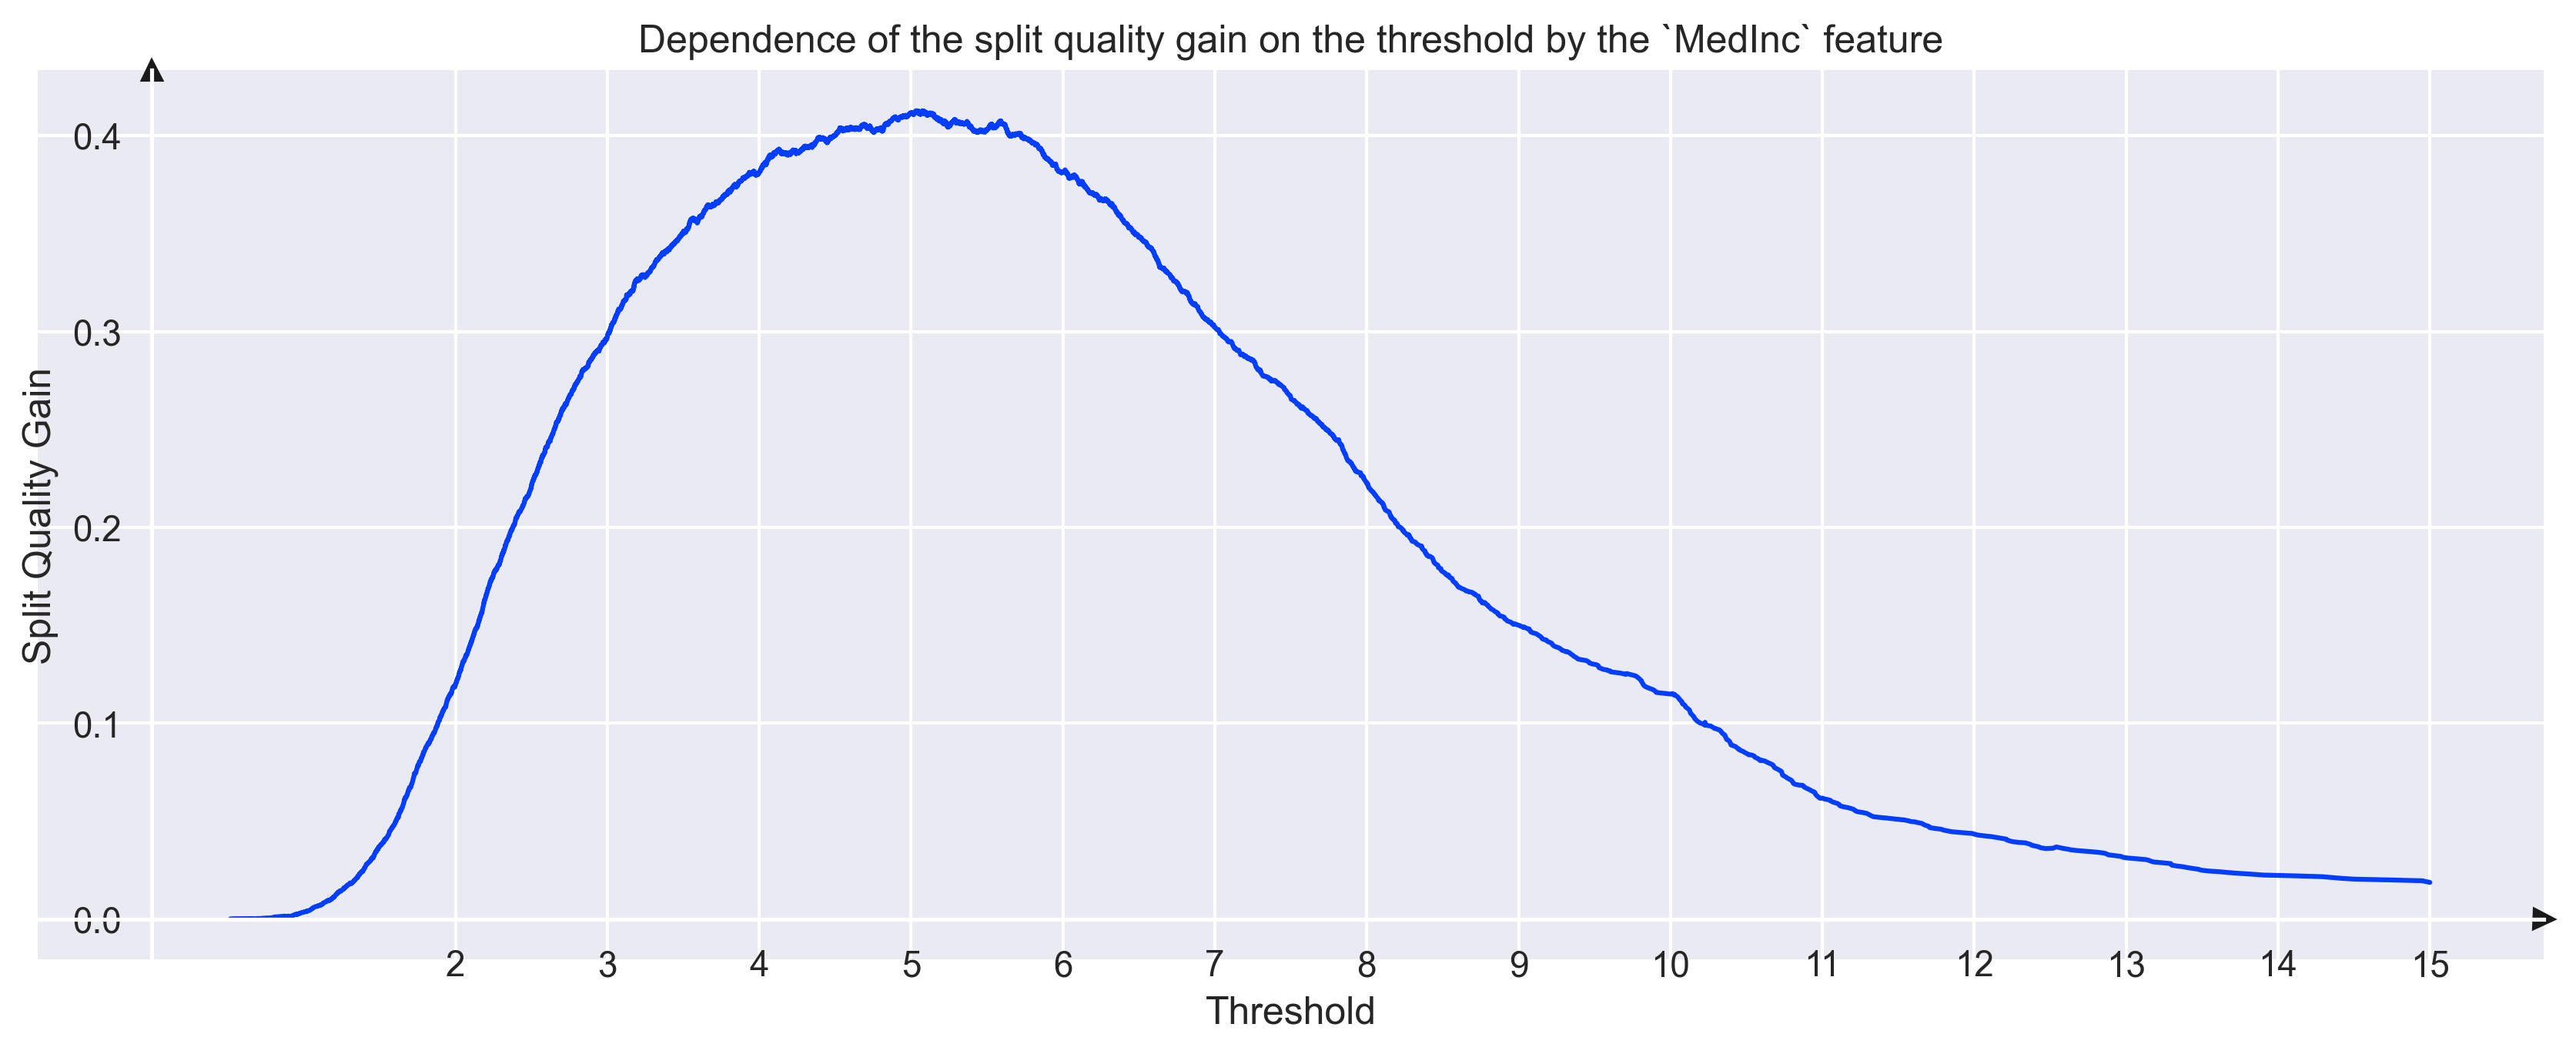

In [210]:
sns.set_theme(palette="bright")
fig, ax = plt.subplots(figsize=(14, 5), dpi=300)

ax.plot(thresholds, criteria)
ax.set_xlabel("Threshold")
ax.set_ylabel("Split Quality Gain")
ax.set_xticks(np.arange(int(thresholds.max())) + 2)
ax.spines["right"].set_color("none")
ax.spines["top"].set_color("none")
ax.spines["bottom"].set_position(("data", 0))
ax.spines["left"].set_position(("data", 0))
ax.plot(1, 0, "k>", transform=ax.get_yaxis_transform(), clip_on=False)
ax.plot(0, 1, "^k", transform=ax.get_xaxis_transform(), clip_on=False)
ax.set_title("Dependence of the split quality gain on the threshold by the `MedInc` feature")
plt.show()


Найдите лучший, с вашей точки зрения, предикат первой вершины решающего дерева.

In [211]:
split_by_feature = X.apply(lambda feature: find_best_split(feature, y, task="regression", feature_type="real")[2:], axis=0)
split_by_feature

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
0,5.035150,51.500000,6.374305,1.103378,1160.500000,3.112543,37.935000,-121.865000
1,0.412751,0.030901,0.159208,0.015253,0.002831,0.073919,0.090334,0.050211


In [212]:
best_split_index = split_by_feature.iloc[1].argmax()
best_split_feature = split_by_feature.columns[best_split_index]
best_split_value = split_by_feature.iloc[1, best_split_index]
print(f"Best predicat: [{best_split_feature} < {best_split_value:6f}]")

Best predicat: [MedInc < 0.412751]


**Задание 2.2 (1 балл)** Разберитесь с написанным кодом решающего дерева, заполните пропуски в коде и реализуйте недостающий метод `_predict_node()`.

Построение дерева осуществляется согласно базовому жадному алгоритму, предложенному в лекции в разделе «Построение дерева».
- **Выбор лучшего разбиения** необходимо производить по критерию Джини.
- **Критерий останова:** все объекты в листе относятся к одному классу или ни по одному признаку нельзя разбить выборку.
- **Ответ в листе:** наиболее часто встречающийся класс в листе.

В задаче также предлагается получить два бонуса, по баллу на каждый!

- **Реализуйте способ обрабатывать пропуски в данных и реализуйте его, пояснив свои действия.**
- **Реализуйте метод оценки важности признаков.**

Бонусные задачи выполнены.

Пропуски обрабатываются следующим образом:
1. Составляем маску объектов, признак которых пропущен.
2. Работаем со всеми объектами с непропущенным признаком.
3. Отправляем объекты с пропущенным признаком в то поддерево, куда ушло больше всего объектов.

Оценка важности признака:
1. Инициализируем список важности признака нулями.
2. Признаку, по которому произошло деление, добавляем важность, равную коэффициенту джини, умноженному на количество объектов, по которым происходило разбиение.
3. Добавлен метод получения списка важности признаков.

In [213]:
class DecisionTree:
    
    def __init__(
        self, 
        feature_types: Union[List[str], np.ndarray], 
        max_depth: int = None, 
        min_samples_split: int = None, 
        min_samples_leaf: int = None,
        task: str = "classification"
    ) -> None:
        
        if np.any(list(map(lambda x: x != "real" and x != "categorical", feature_types))):
            raise ValueError("There is unknown feature type")

        # В этой переменной будем хранить узлы решающего дерева. Каждая вершина хранит в себе идентификатор того,
        # является ли она листовой. Листовые вершины хранят значение класса для предсказания, нелистовые - правого и
        # левого детей (поддеревья для продолжения процедуры предсказания)
        self._tree = {}
        
        # типы признаков (категориальные или числовые)
        self._feature_types = feature_types
        
        # гиперпараметры дерева
        self._max_depth = max_depth
        self._min_samples_split = min_samples_split
        self._min_samples_leaf = min_samples_leaf
        self.task = task
        self._feature_importances = np.zeros(len(feature_types))     
        

    def _fit_node(
        self, 
        sub_X: np.ndarray, 
        sub_y: np.ndarray, 
        node: dict,
        depth: int
    ) -> None:
        
        node["depth"] = depth
        
        # защита от пустых данных
        if len(sub_y) == 0:
            node["type"] = "terminal"
            node["class"] = 0
            return
        
        # критерий останова при достижении глубины дерева
        if self._max_depth is not None and node["depth"] >= self._max_depth:
            node["type"] = "terminal"
            node["class"] = Counter(sub_y).most_common(1)[0][0]
            return
        
        # критерий останова при достижении количества разбиений
        if self._min_samples_split is not None and len(sub_y) < self._min_samples_split:
            node["type"] = "terminal"
            node["class"] = Counter(sub_y).most_common(1)[0][0]
            return

        # критерий останова при равенстве всех обектов одному классу
        if np.all(sub_y == sub_y[0]):
            node["type"] = "terminal"
            node["class"] = sub_y[0]
            return

        # поиск наилучшего разбиения
        feature_best, threshold_best, gini_best, split = None, None, None, None
        for feature in range(sub_X.shape[1]):
            feature_type = self._feature_types[feature]
            cat_to_index = None
            # маска пустых значений
            nan_mask = np.isnan(sub_X[:, feature])

            # подготавливаем признак для поиска оптимального порога
            if feature_type == "real":
                feature_vector = sub_X[:, feature]
            if feature_type == "categorical":
                # преобразование категориальных признаков
                feature_vector = sub_X[:, feature]

                categories = np.unique(feature_vector[~nan_mask])
                if len(categories) > 0:
                    # подсчёт частоты каждой категории
                    pos_ratios = {
                        cat: (sub_y[feature_vector == cat]).mean()
                        for cat in categories
                    }

                    # сортировка категорий по возрастанию и замена на индексы
                    sorted_cats = sorted(categories, key=lambda cat: pos_ratios[cat])
                    cat_to_index = {cat: i for i, cat in enumerate(sorted_cats)}

                    # замена значений признака на соотвествующие их категориям индексы
                    feature_vector = np.vectorize(cat_to_index.get)(feature_vector)

            # работа с непустыми значениями
            valid_features = feature_vector[~nan_mask]
            valid_targets = sub_y[~nan_mask]

            # если валидных значений нет, пропускаем признак
            if len(valid_features) == 0:
                continue

            # сортировка признака и таргета по возрастанию значения признаков
            sort_idx = np.argsort(valid_features)
            sorted_features = valid_features[sort_idx]
            sorted_targets = valid_targets[sort_idx]

            # поиск оптимального порога
            _, _, threshold, gini = find_best_split(sorted_features, sorted_targets, self.task, feature_type)

            # если порог не найден, пропускаем признак
            if threshold is None:
                continue

            # current_split - маска на объекты, которые должны попасть в левое поддерево
            # без учёта пустых значений
            current_split = np.zeros_like(feature_vector, dtype=bool)
            current_split[~nan_mask] = valid_features < threshold
            
            # поиск наибольшего коэффициента Джини
            if gini_best is None or gini > gini_best:
                feature_best = feature
                gini_best = gini
                threshold_best = threshold
                split = current_split
                best_cat_to_index = cat_to_index
                best_nan_mask = nan_mask

        # вычисление важности признака
        if feature_best is not None:
            imputiry_decrease = gini_best * len(sub_y)
            self._feature_importances[feature_best] += imputiry_decrease

        # вершина становится листовой, если все объекты оказались по одну сторону от разбиения
        if split.sum() == 0 or split.sum() == len(split):
            node["type"] = "terminal"
            node["class"] = Counter(sub_y).most_common(1)[0][0]
            return

        # вершина становится листовой, если количество объектов при разбиении оказалось меньше минимального
        if self._min_samples_leaf is not None and (
            split.sum() < self._min_samples_leaf or (np.logical_not(split).sum() < self._min_samples_leaf)
        ):
            node["type"] = "terminal"
            node["class"] = Counter(sub_y).most_common(1)[0][0]
            return

        # записываем полученные сплиты в атрибуты класса
        if feature_best is None:
            node["type"] = "terminal"
            node["class"] = Counter(sub_y).most_common(1)[0][0]
            return
        
        # отправка пустых значений в поддерево с наибольшим количеством объектов
        left_count = np.sum(split & ~best_nan_mask)
        right_count = np.sum(~split & ~best_nan_mask)
        node["nan_direction"] = "left" if left_count > right_count else "right"

        split[best_nan_mask] = node["nan_direction"] == "left"

        # сохранение значений полученой вершины
        node["type"] = "nonterminal"
        if cat_to_index is not None:
            node["cat_to_index"] = best_cat_to_index

        node["feature_split"] = feature_best
        if self._feature_types[feature_best] == "real":
            node["threshold"] = threshold_best
        elif self._feature_types[feature_best] == "categorical":
            node["category_split"] = threshold_best
        else:
            raise ValueError
            
        # обучение левого и правого поддеревьев
        node["left_child"], node["right_child"] = {}, {}
        self._fit_node(sub_X[split], sub_y[split], node["left_child"], depth + 1)
        self._fit_node(sub_X[np.logical_not(split)], sub_y[np.logical_not(split)], node["right_child"], depth + 1)

    def _predict_node(self, x: np.ndarray, node: dict) -> int:
        """
        Предсказание начинается с корневой вершины дерева и рекурсивно идёт в левое или правое поддерево в зависимости от значения
        предиката на объекте. Листовая вершина возвращает предсказание.
        :param x: np.array, элемент выборки
        :param node: dict, вершина дерева
        """
        # если вершина листовая, прогнозируется ее класс
        if node["type"] == "terminal":
            return node["class"]
        
        # получение индекса, типа и значения признака
        feature_index = node["feature_split"]
        feature_type = self._feature_types[feature_index]
        value = x[feature_index]

        # обработка пустого значения
        if np.isnan(value):
            if node["nan_direction"] == "left":
                return self._predict_node(x, node["left_child"])
            else:
                return self._predict_node(x, node["right_child"])
        
        # получение порога разбиения
        if feature_type == "real":
            threshold = node["threshold"]
        elif feature_type == "categorical":
            if "cat_to_index" in node:
                value = node["cat_to_index"].get(value, len(node["cat_to_index"]))
            threshold = node["category_split"]
        
        # отправка признака в левое или правое поддерево
        if value < threshold:
            return self._predict_node(x, node["left_child"])
        return self._predict_node(x, node["right_child"])


    def fit(self, X: np.ndarray, y: np.ndarray) -> None:
        if hasattr(X, 'values'):
            X = X.values
        if hasattr(y, 'values'):
            y = y.values

        # инициализация важности признаков и запуск обучения корневой вершины
        self._feature_importances = np.zeros(len(self._feature_types))
        self._fit_node(X, y, self._tree, 0)

    def predict(self, X: np.ndarray) -> np.ndarray:
        if hasattr(X, 'values'):
            X = X.values

        predicted = []
        for x in X:
            predicted.append(self._predict_node(x, self._tree))
            
        return np.array(predicted)
    
    def get_feature_importances(self) -> np.ndarray:
        """
        :return self._feature_importances: список важности признаков
        """
        return self._feature_importances.copy()

**Задание 2.3 (1 балл)** Загрузите таблицу `students.csv` (это немного преобразованный датасет [User Knowledge](https://archive.ics.uci.edu/ml/datasets/User+Knowledge+Modeling)). В ней признаки объекта записаны в первых пяти столбцах, а в последнем записана целевая переменная (класс: 0 или 1). Постройте на одном изображении пять кривых "порог — значение критерия Джини" для всех пяти признаков. Отдельно визуализируйте диаграммы рассеяния "значение признака — класс" для всех пяти признаков.

In [214]:
df = pd.read_csv("students.csv")
df.head()

,Unnamed: 0,STG,SCG,STR,LPR,PEG,UNS
0,0,0.00,0.00,0.00,0.00,0.00,0
1,1,0.08,0.08,0.10,0.24,0.90,1
2,2,0.06,0.06,0.05,0.25,0.33,0
3,3,0.10,0.10,0.15,0.65,0.30,1
4,4,0.08,0.08,0.08,0.98,0.24,0


In [215]:
X = df.drop(columns=["UNS", "Unnamed: 0"])
y = df["UNS"]
X.head()

,STG,SCG,STR,LPR,PEG
0,0.00,0.00,0.00,0.00,0.00
1,0.08,0.08,0.10,0.24,0.90
2,0.06,0.06,0.05,0.25,0.33
3,0.10,0.10,0.15,0.65,0.30
4,0.08,0.08,0.08,0.98,0.24


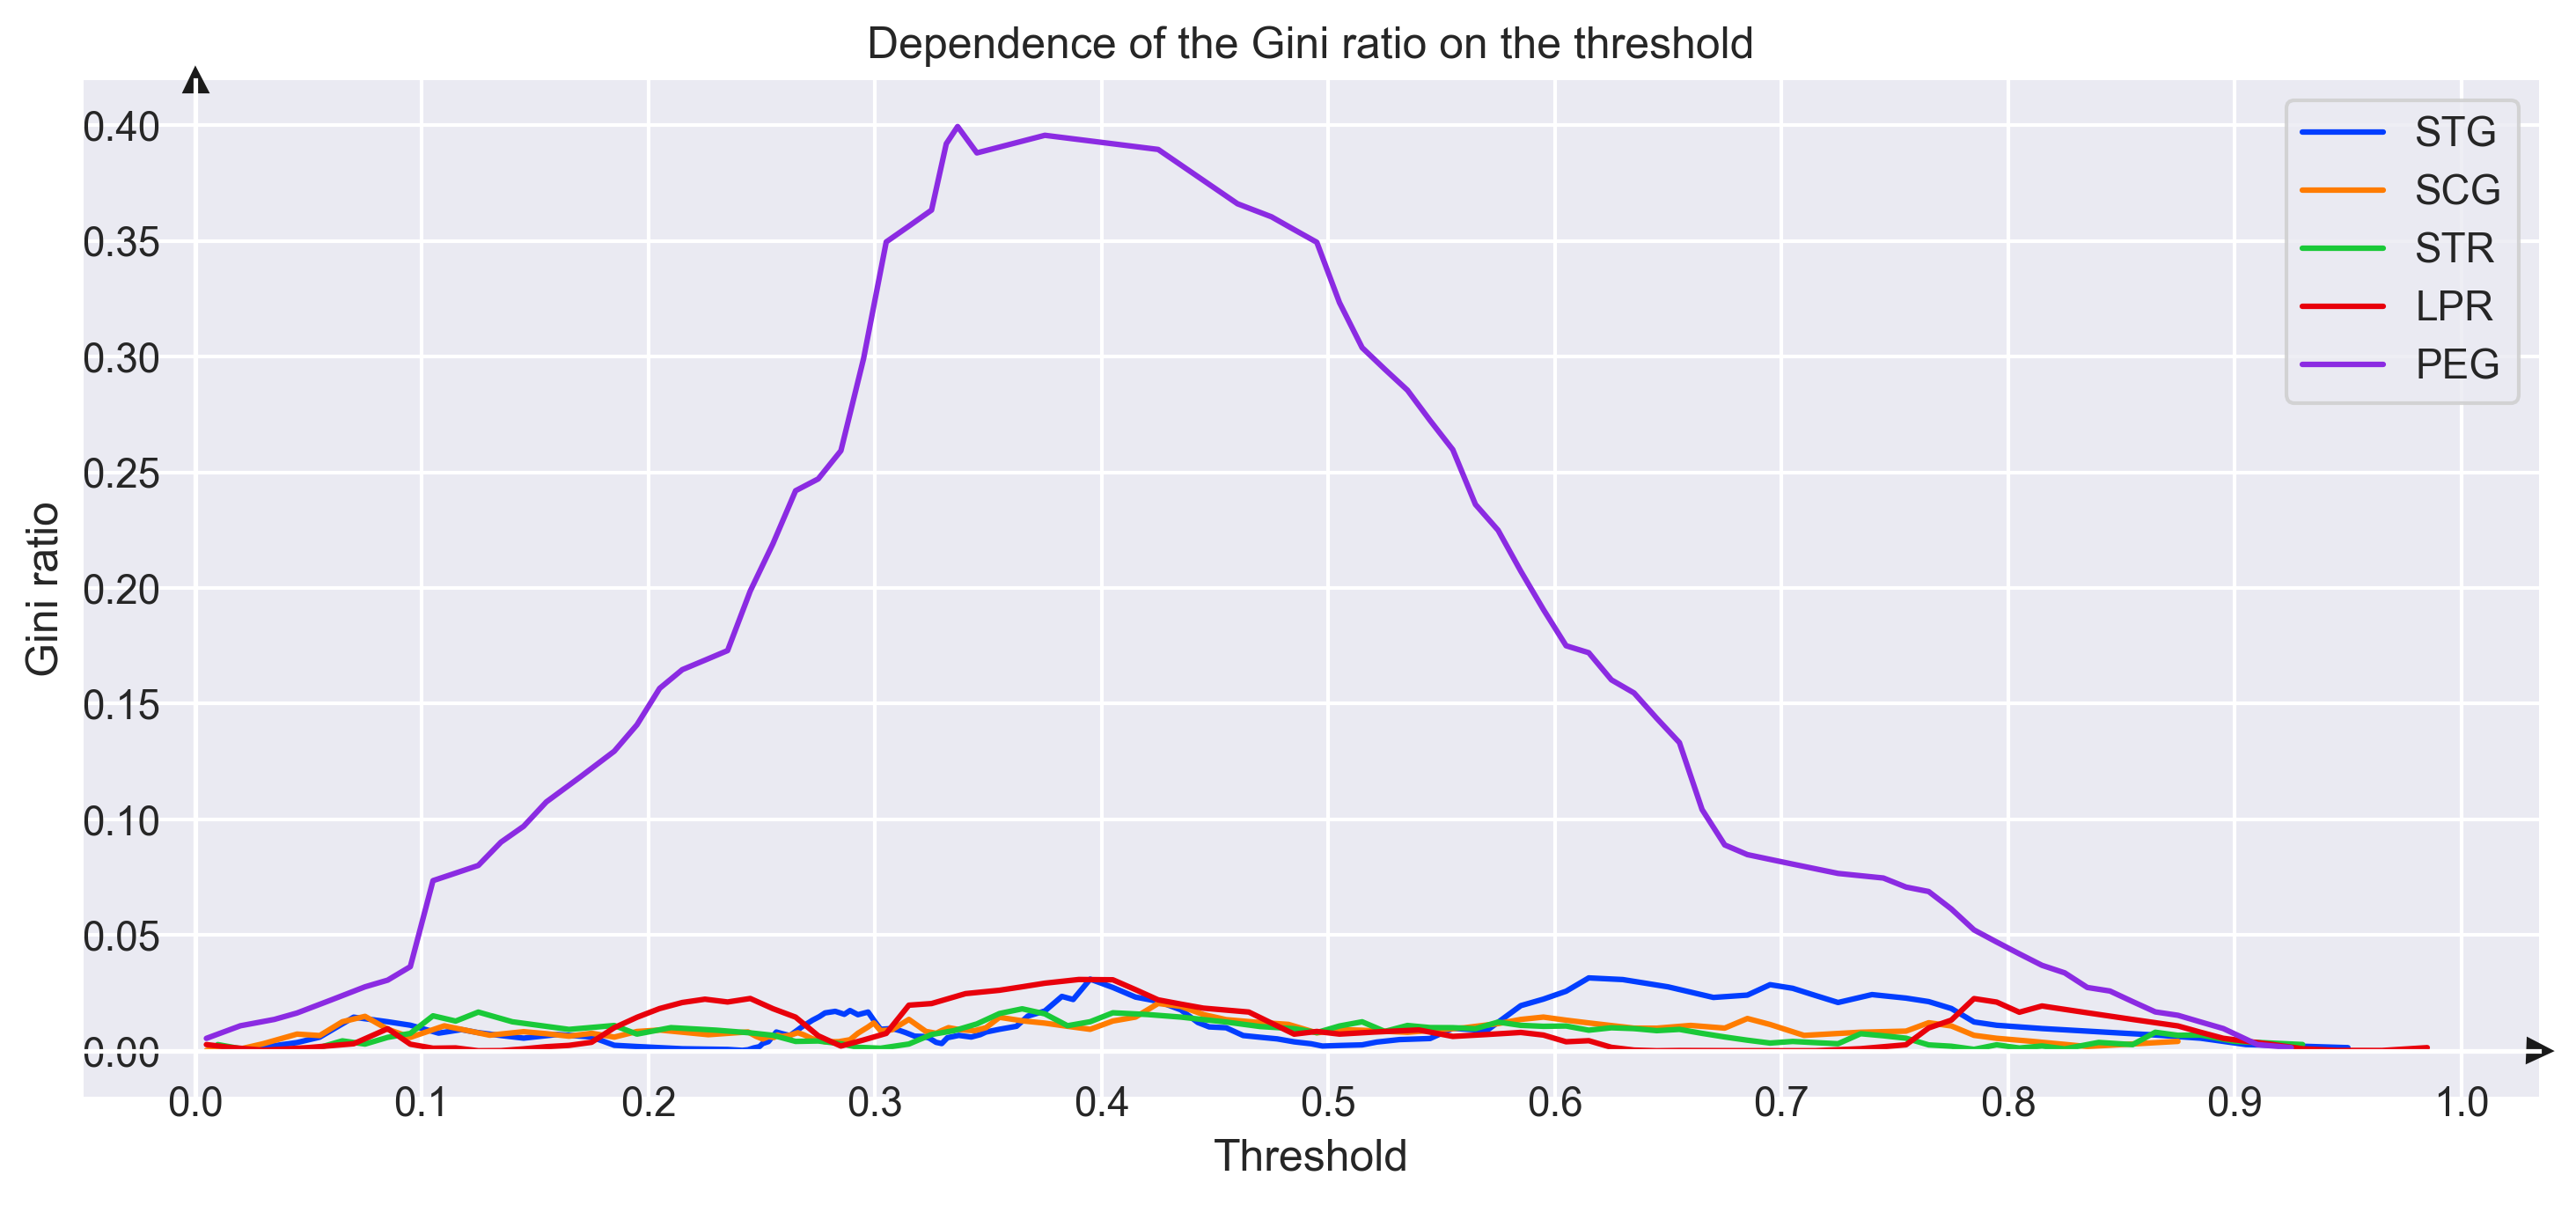

In [216]:
fig, ax = plt.subplots(figsize=(12, 5), dpi=300)

for i in range(5):
    thresholds, gini, threshold_best, gini_best = find_best_split(np.array(X[X.columns[i]]), np.array(y), task="classification", feature_type="real")
    sns.lineplot(x=thresholds, y=gini, label=X.columns[i])

ax.set_xlabel("Threshold")
ax.set_ylabel("Gini ratio")
ax.set_xticks(np.arange(0, 1.05, 0.1))
ax.spines["right"].set_color("none")
ax.spines["top"].set_color("none")
ax.spines["bottom"].set_position(("data", 0))
ax.spines["left"].set_position(("data", 0))
ax.plot(1, 0, "k>", transform=ax.get_yaxis_transform(), clip_on=False)
ax.plot(0, 1, "^k", transform=ax.get_xaxis_transform(), clip_on=False)
ax.set_title("Dependence of the Gini ratio on the threshold")
plt.show()

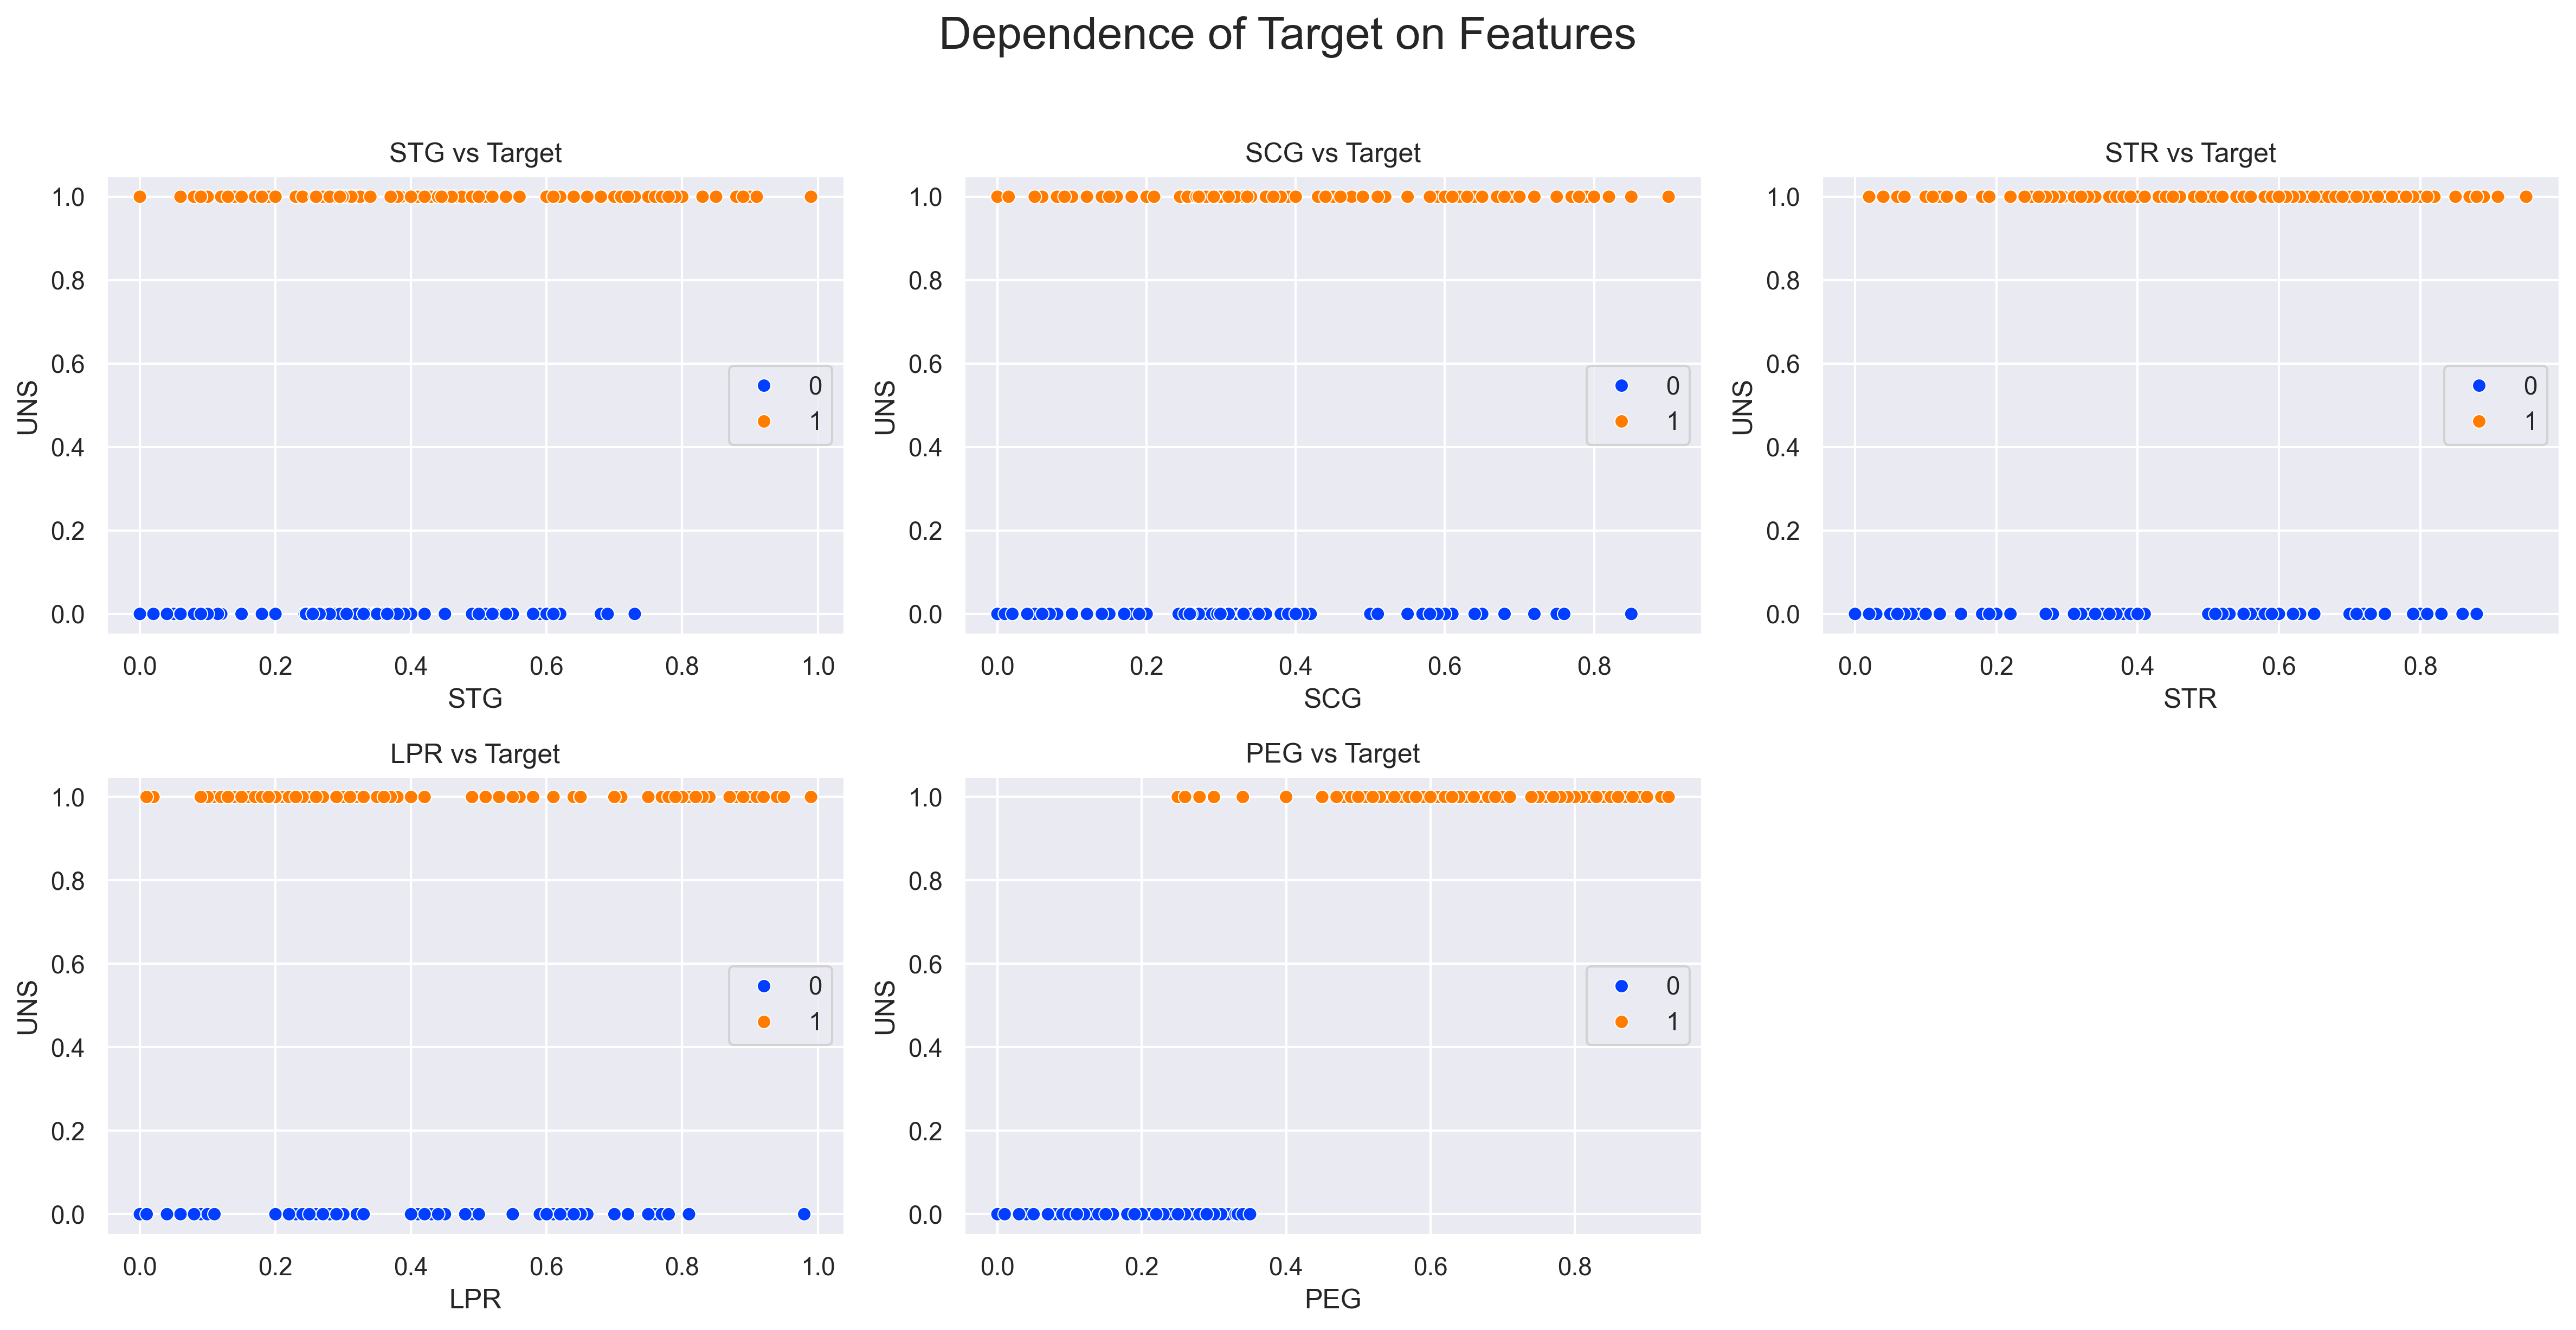

In [217]:
fig, axes = plt.subplots(2, 3, figsize=(16, 8), dpi=300)
axes = axes.flatten()

for i in range(5):
    sns.scatterplot(x=X[X.columns[i]], y=y, hue=y, ax=axes[i])
    axes[i].set_title(f"{X.columns[i]} vs Target")
    axes[i].legend(loc="center right")

axes[5].axis("off")

plt.suptitle("Dependence of Target on Features", fontsize=20, y=1.02)
plt.tight_layout()
plt.show()

Исходя из кривых значений критерия Джини, по какому признаку нужно производить деление выборки на два поддерева? Согласуется ли этот результат с визуальной оценкой диаграмм рассеяиния? Как бы охарактеризовали вид кривой для "хороших" признаков, по которым выборка делится почти идеально? Чем отличаются кривые для признаков, по которым деление практически невозможно?

### Ответ:

Судя по первому графику, деление необходимо производить по признаку `PEG`, так как он единственный даёт высокое значение критерия Джини с максимальным значение около $0.4$ при пороге деления приблизительно $3.3$. Остальные признаки дают одинаковые значения меньше $0.05$ при всех порогах.

Это же хорошо видно и по диаграммам рассеяиния - у признака `PEG` можно чётко разделить объекты по их классу (больше $0.4$ первый класс, а то, что меньше - прктически все объекты относятся к другому классу), а у остальных признаков классы сильно перемешаны, потому что таргет `1` расположен почти на всём пространстве значений. 

Вид кривой "хороших" признаков имеет нормальное распределение, с явным максимальным значением. А для признаков, деление по которым почти невозможно, график схож с равномерным распределением - при всех значениях порога получается примерно одинаково низкие значения критерия Джини. Это можно объяснить тем, что у "хороших" признаков чем ближе к лучшему разбиению, тем выше критерий Джини - следовательно, так выделяется лучший порог, а значения критерия возле него также высокие, потому что всё ещё можно хорошо поделить выборку, но уже не так чётко. 

**Задание 2.4 (1 балл)** Протестируйте свое решающее дерево на датасете [mushrooms](https://archive.ics.uci.edu/ml/datasets/Mushroom). 

1. Скачайте таблицу `agaricus-lepiota.data` (из [Data Folder](https://archive.ics.uci.edu/ml/machine-learning-databases/mushroom/)), 
2. Считайте таблицу при помощи `pandas`,
3. Примените к каждому столбцу `LabelEncoder` (из `sklearn`), чтобы преобразовать строковые имена категорий в натуральные числа. 

Первый столбец — это целевая переменная (e — edible, p — poisonous) Мы будем измерять качество с помощью accuracy, так что нам не очень важно, что будет классом 1, а что — классом 0. Обучите решающее дерево на половине случайно выбранных объектов (признаки в датасете категориальные) и сделайте предсказания для оставшейся половины. Вычислите accuracy.

In [218]:
#!pip install ucimlrepo

In [219]:
from ucimlrepo import fetch_ucirepo 
from sklearn.preprocessing import LabelEncoder

mushroom = fetch_ucirepo(id=73) 

In [220]:
X = mushroom.data.features 
y = mushroom.data.targets 

X.head(5)

,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,stalk-shape,...,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,x,s,n,t,p,f,c,n,k,e,...,s,w,w,p,w,o,p,k,s,u
1,x,s,y,t,a,f,c,b,k,e,...,s,w,w,p,w,o,p,n,n,g
2,b,s,w,t,l,f,c,b,n,e,...,s,w,w,p,w,o,p,n,n,m
3,x,y,w,t,p,f,c,n,n,e,...,s,w,w,p,w,o,p,k,s,u
4,x,s,g,f,n,f,w,b,k,t,...,s,w,w,p,w,o,e,n,a,g


In [221]:
X = X.copy()

encoder = LabelEncoder()
for i in X.columns:
    X[i] = encoder.fit_transform(X[i])

y = encoder.fit_transform(y)

X.head()

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,stalk-shape,...,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,5,2,4,1,6,1,0,1,4,0,...,2,7,7,0,2,1,4,2,3,5
1,5,2,9,1,0,1,0,0,4,0,...,2,7,7,0,2,1,4,3,2,1
2,0,2,8,1,3,1,0,0,5,0,...,2,7,7,0,2,1,4,3,2,3
3,5,3,8,1,6,1,0,1,5,0,...,2,7,7,0,2,1,4,2,3,5
4,5,2,3,0,5,1,1,0,4,1,...,2,7,7,0,2,1,0,3,0,1


In [222]:
np.unique(y)

array([0, 1])

In [223]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [224]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42, stratify=y)

tree = DecisionTree(np.array(["categorical" for _ in range(X_train.shape[1])]), task="classification")

tree.fit(X_train, y_train)
predict_train = tree.predict(X_train)
print(f"Train accuracy: {accuracy_score(y_train, predict_train)}")

predict_test = tree.predict(X_test)
print(f"Test accuracy:  {accuracy_score(y_test, predict_test)}")

Train accuracy: 1.0
Test accuracy:  1.0


In [225]:
tree.get_feature_importances()

array([0.00000000e+00, 5.97188192e+00, 0.00000000e+00, 0.00000000e+00,
       1.89475813e+03, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 1.52380952e+01, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 2.81834494e+01, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 8.42051697e+01,
       0.00000000e+00, 1.94433779e-02])

Дерево отлично справилось со своей задаче, и, как всегда, переобучилось! 

Попробуем добавить гиперпараметры.

In [227]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42, stratify=y)

tree = DecisionTree(
    feature_types=np.array(["categorical" for _ in range(X_train.shape[1])]),
    max_depth=3,
    min_samples_split=100,
    min_samples_leaf=50,
    task="classification"
)

tree.fit(X_train, y_train)
predict_train = tree.predict(X_train)
print(f"Train accuracy: {accuracy_score(y_train, predict_train):.4f}")

predict_test = tree.predict(X_test)
print(f"Test accuracy:  {accuracy_score(y_test, predict_test):.4f}")

print(f"\nFeature importancy:\n{tree.get_feature_importances()}")

Train accuracy: 0.9830
Test accuracy:  0.9874

Feature importancy:
[   0.            0.            0.            0.         1894.7581298
    0.            0.            0.            0.            0.
    0.            0.            0.            0.            0.
    0.            0.            0.            0.           84.20516968
    0.            0.        ]


Дерево стало немного менее переобученным)))

## Часть 3: Бэггинг и случайный лес (4 балла)

В данной части мы будем работать [с задачей предсказания диабета у пациента](https://www.kaggle.com/uciml/pima-indians-diabetes-database/data). Посмотрим на работу бэггинга над решающими деревьями и случайного леса, сравним их работу.

In [149]:
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier

In [150]:
data = pd.read_csv('diabetes.csv')
print(f"Dataset shape: {data.shape}")
data.head()

Dataset shape: (768, 9)


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


Посмотрим на распределение целевой переменной

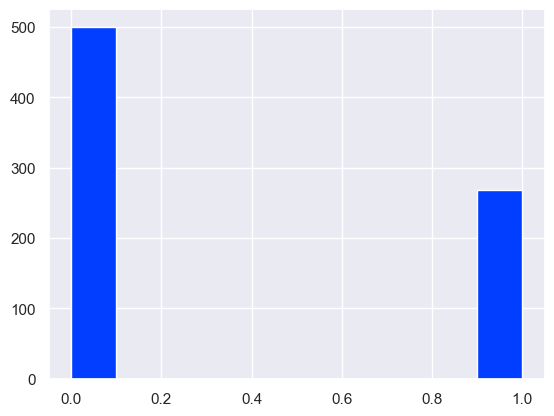

In [151]:
data['Outcome'].hist()
plt.show()

**Задание 3.1 (0.5 балла)** Разделите данные на признаки и целевую переменную. Разбейте датасет на обучающую и тестовую части в отношении 7:3. Затем разделите обучающую выборку на обучающую-обучающую и обучающую-валидационную в соотношении 7:3 (то есть в итоге должно получиться три выборки: обучающая-обучающая (0.49 от исходного датасета), обучающая-валидационная (0.21 от исходного датасета) и тестовая (0.3 от исходного датасета).

In [152]:
X = data.drop(columns=["Outcome"])
y = data["Outcome"]

X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.3, random_state=42, stratify=y_temp)

print(f"Train shape: {X_train.shape}")
print(f"Val shape: {X_val.shape}")
print(f"Test shape: {X_test.shape}")

Train shape: (375, 8)
Val shape: (162, 8)
Test shape: (231, 8)


**Задание 3.2 (1 балл)** На обучающей-валидационной выборке подберите оптимальные значения гиперпараметров `max_depth` и `min_samples_leaf` для `DecisionTreeClassifier`. Для этого:
1. Создайте списки с возможными значениями для перебора.
2. Для каждой пары значений обучите дерево на обучающей-обучающей выборке и определите качество на обучающей-валидационной выборке. В качестве критерия будем использовать `f1-меру`.
3. Выберите ту пару значений, которая даёт наилучшее качество на обучающей-валидационной выборке. 


Обучите решающее дерево с подобранными гиперпараметрами на **полной обучающей** выборке. Оцените качество классификации на тестовой выборке по метрикам `accuracy`, `precision` и `recall`, `auc_roc`.

In [153]:
max_depth_validation = np.arange(1, 20, 1)
min_samples_leaf_validation = np.arange(1, 20, 1)

best_max_depth = None
best_min_samples_leaf = None
best_f1 = 0

for max_depth in max_depth_validation:
    for min_samples_leaf in min_samples_leaf_validation:
        tree = DecisionTreeClassifier(max_depth=max_depth, min_samples_leaf=min_samples_leaf)
        tree.fit(X_train, y_train)

        predict_val = tree.predict(X_val)
        f1 = f1_score(y_val, predict_val)

        if f1 > best_f1:
            best_max_depth = max_depth
            best_min_samples_leaf = min_samples_leaf
            best_f1 = f1

print(f"max_depth: {best_max_depth}")
print(f"min_sample_leaf: {best_min_samples_leaf}")
print(f"f1: {best_f1}")

max_depth: 5
min_sample_leaf: 17
f1: 0.625


In [160]:
tree = DecisionTreeClassifier(max_depth=best_max_depth, min_samples_leaf=best_min_samples_leaf, random_state=42)
tree.fit(X_temp, y_temp)

predict_tree = tree.predict(X_test)

accuracy = accuracy_score(y_test, predict_tree)
precision = precision_score(y_test, predict_tree)
recall = recall_score(y_test, predict_tree)
roc_auc = roc_auc_score(y_test, predict_tree)

print("DECISION TREE")
print(f"Accuracy:\t{accuracy:.4f}")
print(f"Precision:\t{precision:.4f}")
print(f"Recall:\t\t{recall:.4f}")
print(f"Roc-Auc:\t{roc_auc:.4f}")

DECISION TREE
Accuracy:	0.7576
Precision:	0.7193
Recall:		0.5062
Roc-Auc:	0.6998


**Задание 3.3 (0.5 балла)** Обучите [`BaggingClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.BaggingClassifier.html) на 50 деревьях на **полной обучающей** выборке. Оцените качество классификации на тестовой выборке по тем же метрикам.

In [161]:
bagging = BaggingClassifier(n_estimators=50, random_state=42)

bagging.fit(X_temp, y_temp)

y_pred = bagging.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)

print("BAGGING")
print(f"Accuracy:\t{accuracy:.4f}")
print(f"Precision:\t{precision:.4f}")
print(f"Recall:\t\t{recall:.4f}")
print(f"Roc-Auc:\t{roc_auc:.4f}")

BAGGING
Accuracy:	0.7532
Precision:	0.6875
Recall:		0.5432
Roc-Auc:	0.7049


**Задание 3.4 (1 балл)** Выполните кросс-валидацию на полной обучающей выборке и подберите оптимальные значения гиперпараметров `max_depth` и `min_samples_split` для `Random Forest` с 50 деревьями. Для этого:

1. Создайте списки с возможными значениями для перебора.
2. Для каждой пары значений проведите кросс-валидацию на полной обучающей выборке. Количество разбиений выберите на ваш вкус. В качестве критерия будем использовать `f1-меру`. Усредните значение критерия по всем прогонам кросс-валидации. 
3. Выберите ту пару значений, которая даёт наилучшее среднее качество. 

Обучите случайный лес с подобранными гиперпараметрами на **полной обучающей** выборке. Оцените качество классификации по тем же метрикам. Какая из трёх построенных моделей показала себя лучше?

In [162]:
from sklearn.model_selection import cross_val_score

max_depth_validation = np.arange(1, 20, 1)
min_samples_split_validation = np.arange(2, 20, 1)

best_max_depth = None
best_min_samples_split = None
best_f1 = 0

for max_depth in max_depth_validation:
    for min_samples_split in min_samples_split_validation:
        forest = RandomForestClassifier(n_estimators=50, max_depth=max_depth, min_samples_split=min_samples_split, random_state=42)
        f1 = cross_val_score(forest, X_train, y_train, scoring="f1", cv=5)
        f1_mean= f1.mean()

        if f1_mean > best_f1:
            best_max_depth = max_depth
            best_min_samples_split = min_samples_split
            best_f1 = f1_mean

print(f"max_depth: {best_max_depth}")
print(f"min_samples_split: {best_min_samples_split}")
print(f"f1: {best_f1:.4f}")

max_depth: 10
min_samples_split: 7
f1: 0.6813


In [163]:
forest = RandomForestClassifier(n_estimators=50, max_depth=best_max_depth, min_samples_split=best_min_samples_split, random_state=42)
forest.fit(X_temp, y_temp)

y_pred = forest.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)

print("RANDOM FOREST")
print(f"Accuracy:\t{accuracy:.4f}")
print(f"Precision:\t{precision:.4f}")
print(f"Recall:\t\t{recall:.4f}")
print(f"Roc-Auc:\t{roc_auc:.4f}")

RANDOM FOREST
Accuracy:	0.7576
Precision:	0.6923
Recall:		0.5556
Roc-Auc:	0.7111


Полученные результаты:

Metric | DECISION TREE | BAGGING | RANDOM FOREST
-------|---------------|---------|--------------
Accuracy |	0.7532 | 0.7532 | 0.7576
Precision |	0.7308 | 0.6875 | 0.6923
Recall |	0.4691 | 0.5432 | 0.5556
Roc-Auc |	0.6879 | 0.7049 | 0.7111

В целом результаты везде примерно одинаковые, если смотреть на основыне метрики - accuracy и roc-auc. Чуть лучше получились у BAGGING и RANDOM FOREST, особенно на recall.

**Задание 3.5 (0.5 балла)** Постройте график зависимости AUC ROC на тестовой выборке от числа деревьев (`n_estimators`) для случайного леса, обучаемого на **полной обучающей** выборке. Какие выводы можно сделать?

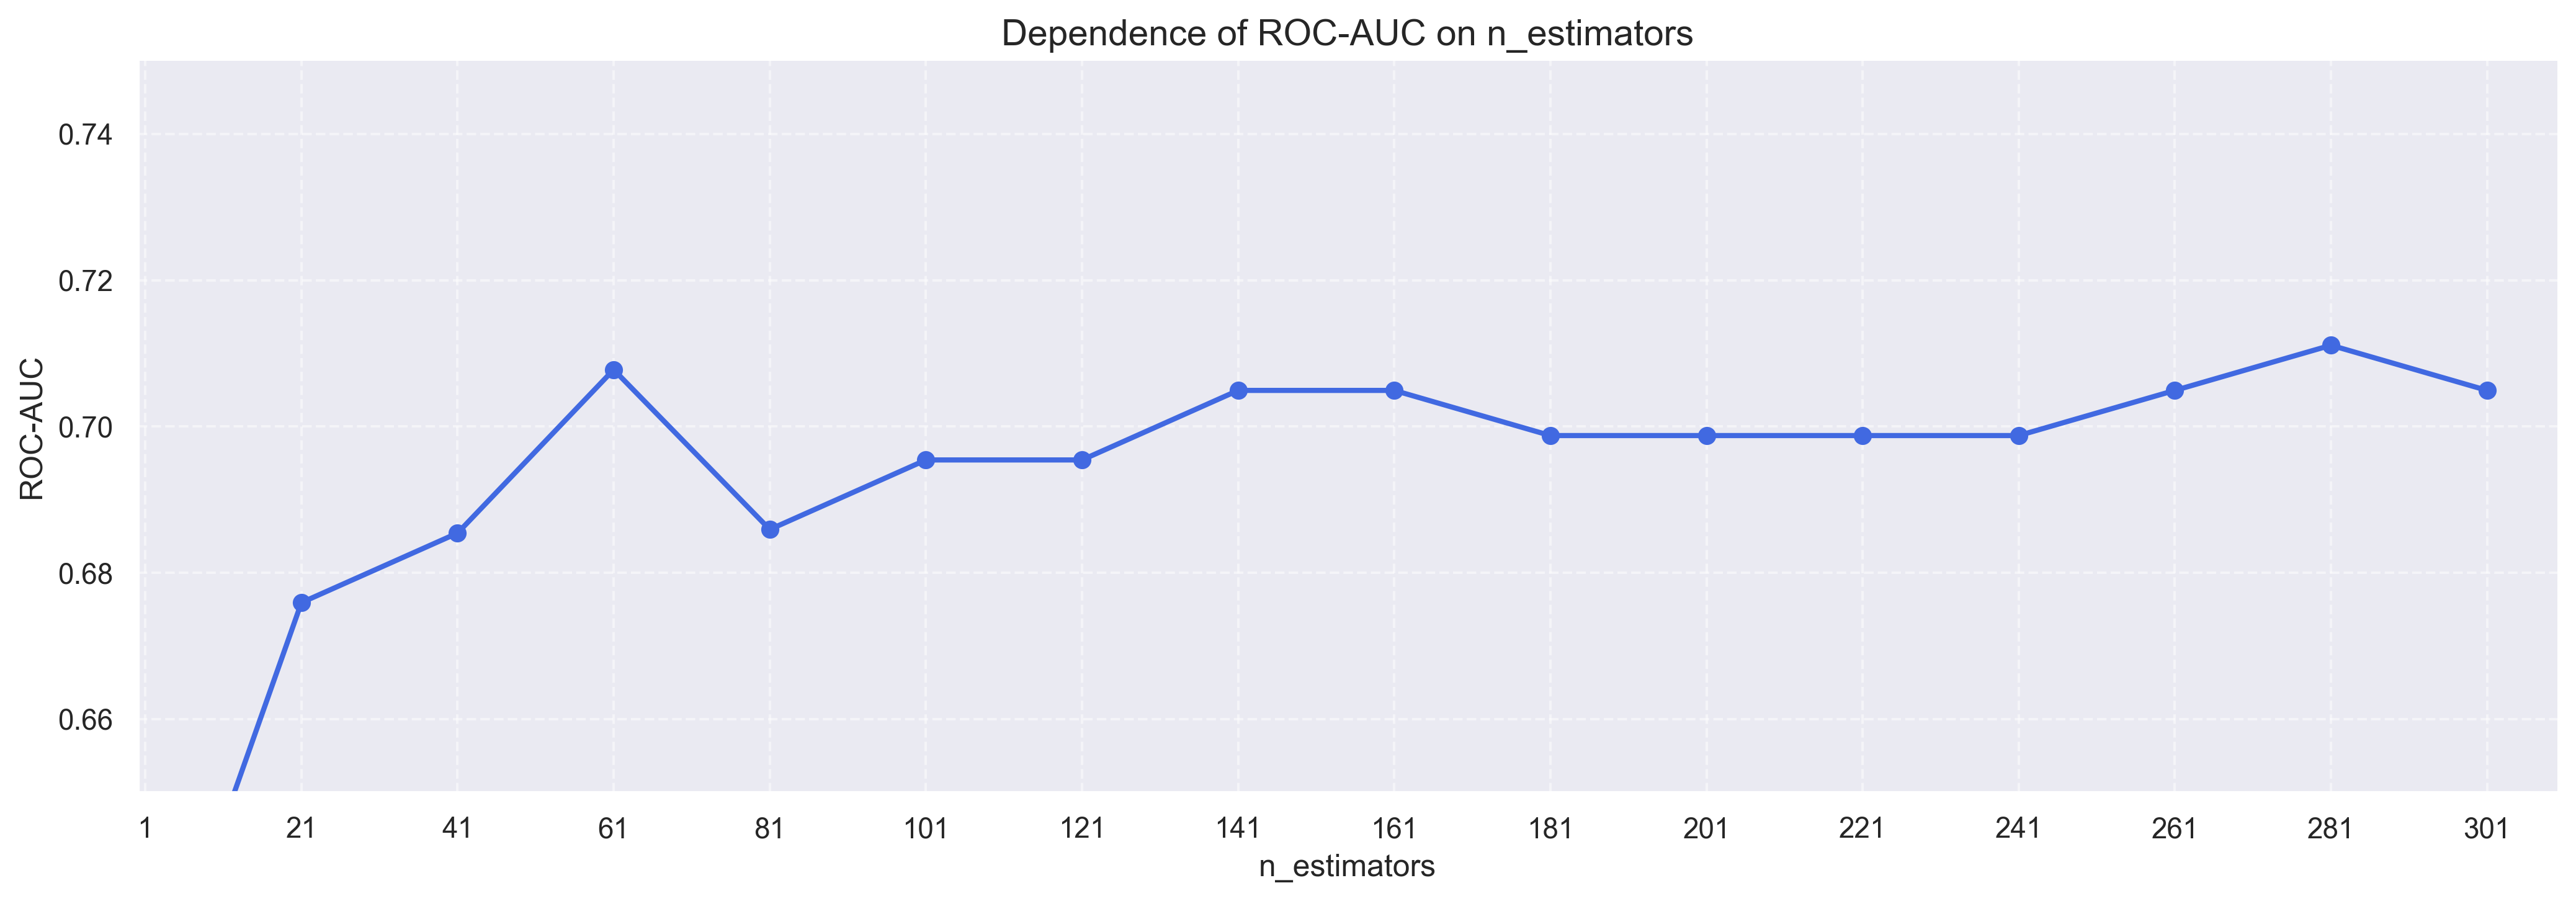

In [158]:
fig, ax = plt.subplots(figsize=(14, 5), dpi=300)

estimators_range = np.arange(1, 302, 20)
roc_auc_values = []

for i in estimators_range:
    forest = RandomForestClassifier(
        n_estimators=i, 
        max_depth=best_max_depth,
        min_samples_split=best_min_samples_split, 
        random_state=42
    )
    forest.fit(X_temp, y_temp)

    y_pred = forest.predict(X_test)
    roc_auc = roc_auc_score(y_test, y_pred)

    roc_auc_values.append(roc_auc)

ax.plot(estimators_range, roc_auc_values, marker='o', color='royalblue', linewidth=2, label='ROC-AUC')

ax.set_xlabel("n_estimators", fontsize=12)
ax.set_ylabel("ROC-AUC", fontsize=12)
ax.set_ylim(0.65, 0.75)
ax.set_xlim(0, 310)

ax.set_xticks(estimators_range)
ax.grid(True, linestyle='--', alpha=0.5)

ax.spines["right"].set_color("none")
ax.spines["top"].set_color("none")

ax.set_title("Dependence of ROC-AUC on n_estimators", fontsize=14)

plt.tight_layout()
plt.show()

До опеределённого значения при увеличении количества деревьев ROC-AUC растёт. Дальше увеличение деревьев особого улучшения не даёт, метрика то растёт немного, то падает. То есть хорошее значение достигается в окрестностях `n_estimators` = $61$, а дальше нет большого смысла улчшать модель количеством деревьев.

**Задание 3.6 (0.5 балла)** Для лучшей модели случайного леса из **Задания 3.4** посчитайте важность признаков и постройте bar plot. Какой признак оказался самым важным для определения диабета?

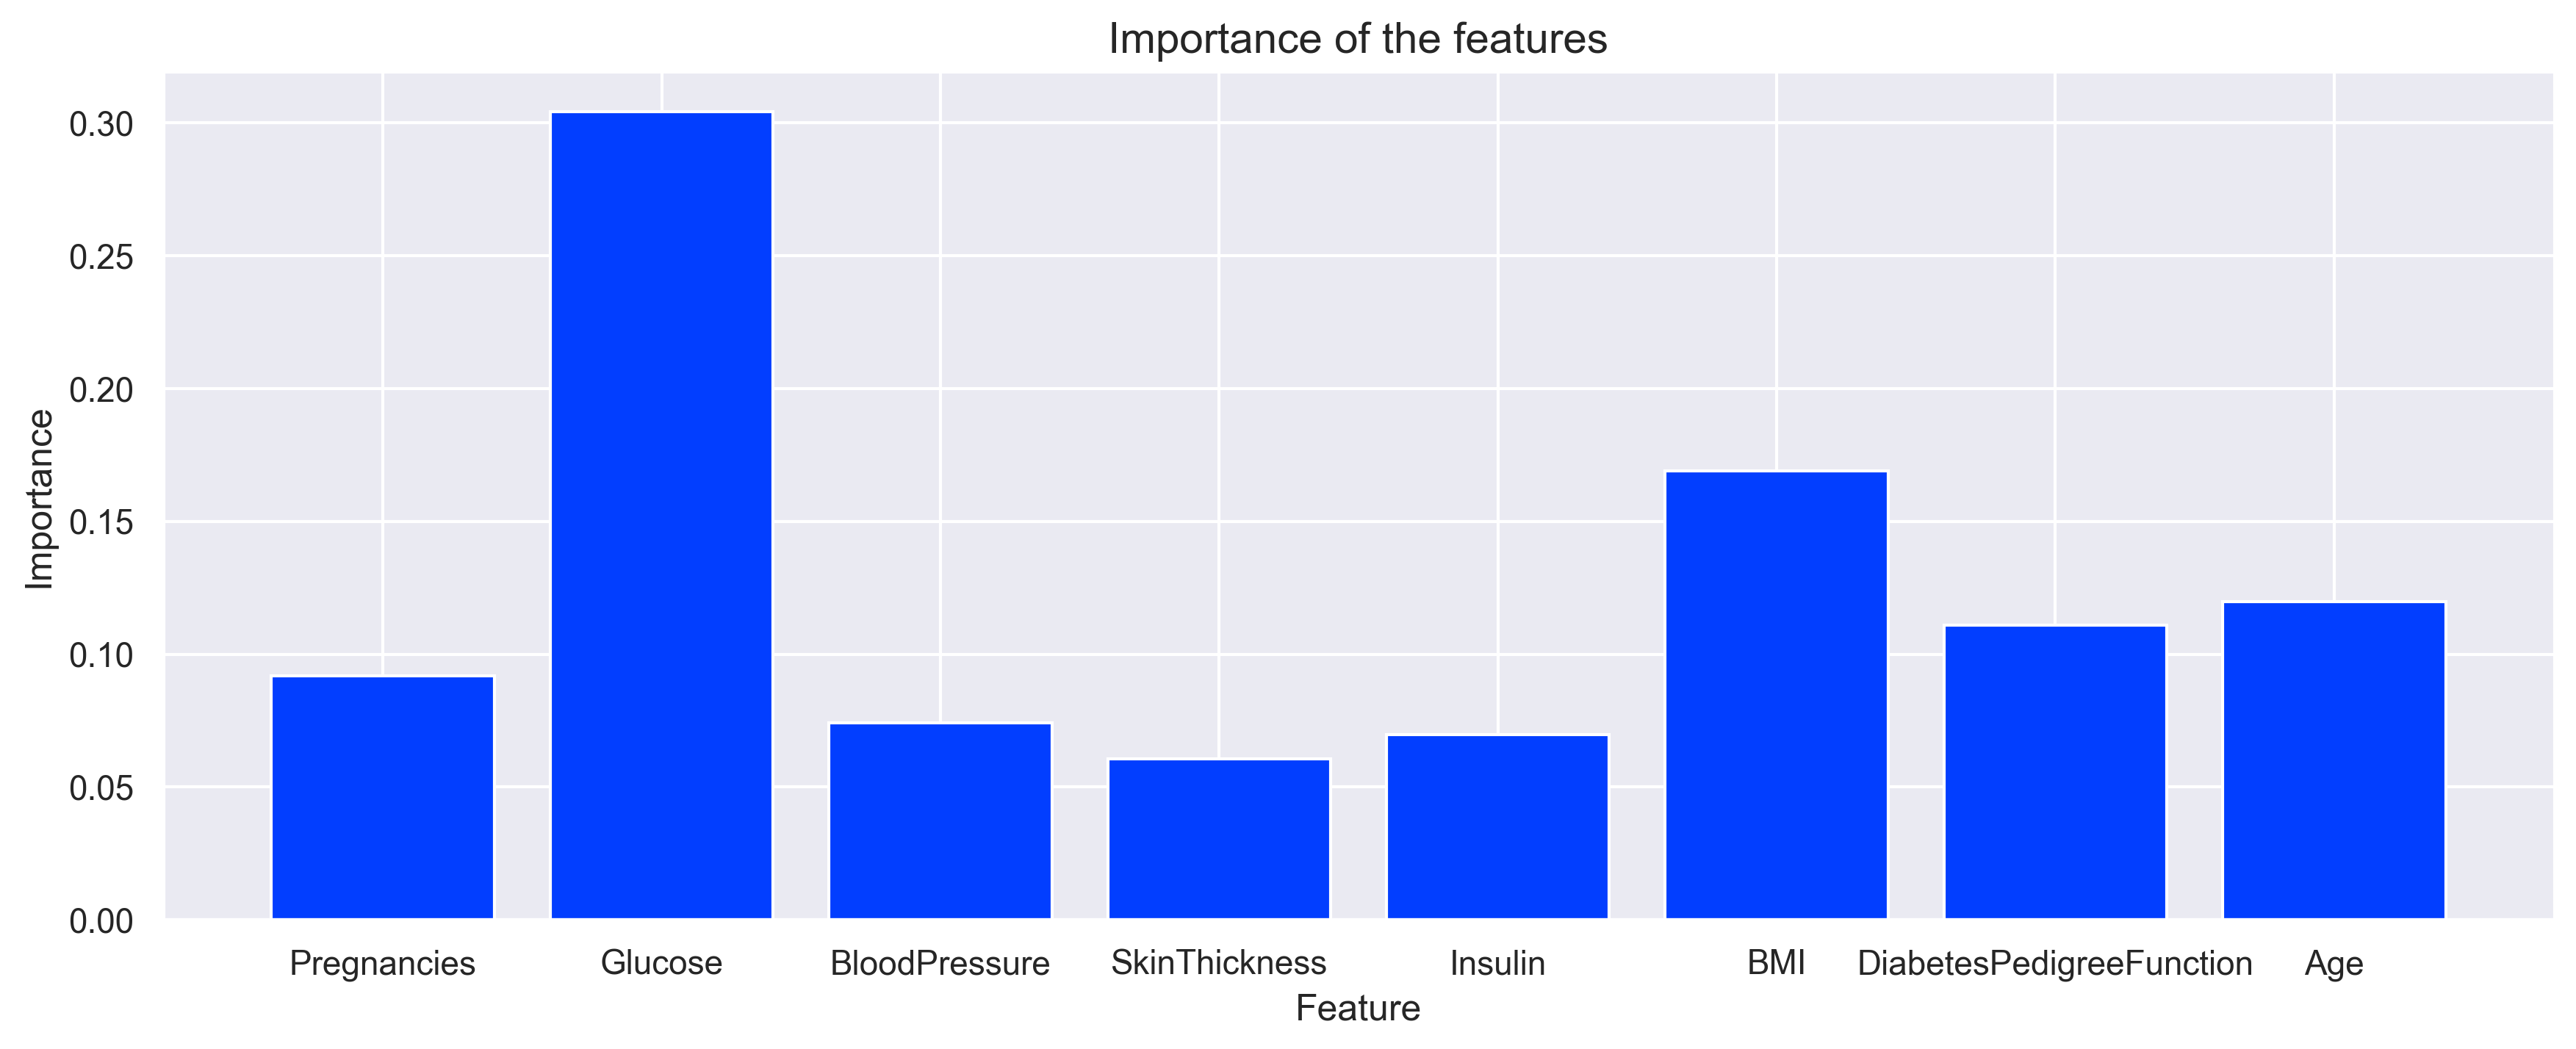

In [ ]:
forest = RandomForestClassifier(
    n_estimators=50, 
    max_depth=best_max_depth, 
    min_samples_split=best_min_samples_split, 
    random_state=42
)
forest.fit(X_temp, y_temp)
features_importances = forest.feature_importances_

fig, ax = plt.subplots(figsize=(14, 5), dpi=300)

ax.bar(X.columns, features_importances)
ax.set_xlabel("Feature", fontsize=12)
ax.set_ylabel("Importance", fontsize=12)
ax.set_title("Importance of the features", fontsize=14)

plt.show()

Самым важным признаком оказался `Glucose`, который явно выделяется среди остальных и имеет важность в 30%, что почти в 2 раза больше, чем другие признаки. Также чуть больше выделяются признаки `BMI`, `Age` и немного `DiabetesPedigreeFunction`, которые имеют важность более 10%.

<img src="https://raw.githubusercontent.com/vasyukov1/HSE-FCS-SE-2-year/refs/heads/main/IAD/homeworks/hw07-trees/meme_lion.jpg" alt="meme_lion" style="width: 700px;"/>